# Projeto Individual 2 - Fundamentos de Sistemas Inteligentes

In [1]:
pip install numpy sklearn matplotlib TensorFlow --upgrade


Requirement already up-to-date: numpy in /home/gabriel/anaconda3/lib/python3.7/site-packages (1.21.5)
Requirement already up-to-date: sklearn in /home/gabriel/anaconda3/lib/python3.7/site-packages (0.0)
Requirement already up-to-date: matplotlib in /home/gabriel/anaconda3/lib/python3.7/site-packages (3.5.1)
Requirement already up-to-date: TensorFlow in /home/gabriel/anaconda3/lib/python3.7/site-packages (2.8.0)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from keras.layers.core import Dense, Flatten
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import pathlib

import sklearn as sk
from sklearn.metrics import classification_report

### Preparatŕoio para as imagens e funções de treino e validação das imagens

In [3]:
data_dir = 'Tomato-pest-image-enhancement'
img_height,img_width=299,299                  #tamanho das imagens

train_ds = tf.keras.preprocessing.image_dataset_from_directory( #Função de treino
  data_dir,
  labels='inferred',
  label_mode='categorical',
  class_names = None,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=32)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(   #Função de validação
  data_dir,
  labels='inferred',
  label_mode='categorical',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=32)

Found 4263 files belonging to 8 classes.
Using 3411 files for training.
Found 4263 files belonging to 8 classes.
Using 852 files for validation.


### Teste pra verificar as imagens

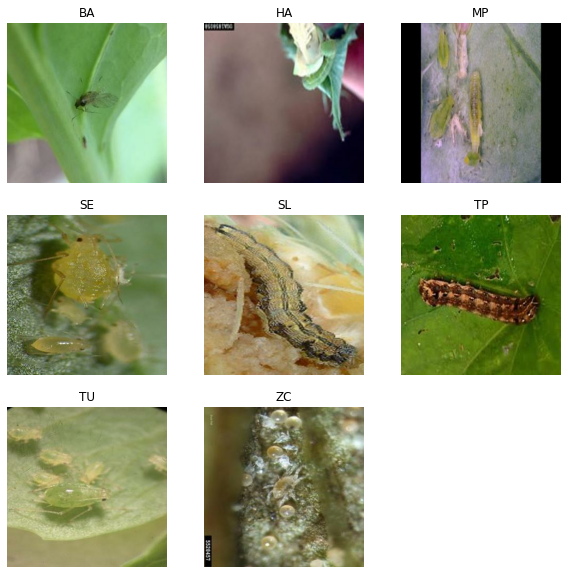

In [4]:
class_names = train_ds.class_names    #variável para facilitar as labels

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

## Criando o modelo com aplicação ResNet50

In [5]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(
                    include_top=False,
                    input_shape=(299,299,3),
                    pooling='avg',
                    classes=8,
                    weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

In [6]:
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(8, activation='softmax'))

In [7]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 24,640,904
Trainable params: 1,053,192
Non-trainable params: 23,587,712
_________________________________________________________________


### Usando 15 Epoch pra treinamento

In [8]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=15)

Epoch 1/15
107/107 [==============================] - 30s 228ms/step - loss: 0.5989 - accuracy: 0.7921 - val_loss: 0.2670 - val_accuracy: 0.9073
Epoch 2/15
107/107 [==============================] - 23s 212ms/step - loss: 0.1625 - accuracy: 0.9478 - val_loss: 0.2243 - val_accuracy: 0.9261
Epoch 3/15
107/107 [==============================] - 23s 217ms/step - loss: 0.0699 - accuracy: 0.9821 - val_loss: 0.1526 - val_accuracy: 0.9542
Epoch 4/15
107/107 [==============================] - 23s 217ms/step - loss: 0.0322 - accuracy: 0.9941 - val_loss: 0.1311 - val_accuracy: 0.9566
Epoch 5/15
107/107 [==============================] - 22s 203ms/step - loss: 0.0197 - accuracy: 0.9971 - val_loss: 0.1493 - val_accuracy: 0.9542
Epoch 6/15
107/107 [==============================] - 22s 202ms/step - loss: 0.0129 - accuracy: 0.9985 - val_loss: 0.1041 - val_accuracy: 0.9683
Epoch 7/15
107/107 [==============================] - 22s 209ms/step - loss: 0.0060 - accuracy: 0.9994 - val_loss: 0.0933 - val_ac

#### Relação de treino e validação para cada rodada dos Epochs

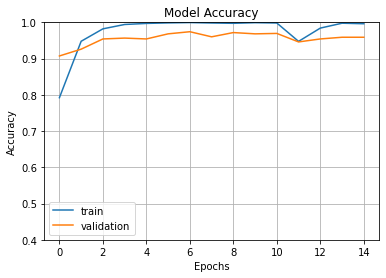

In [9]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

### Setando as variáveis y_true e y_pred para obtenção dos valores de acurácia, revocação e f1

In [10]:
y_true = []
y_pred = []
imgs_array = []

for imgs,names in val_ds:           # Esses dados são gerados em Batches de tamanho 32, então é necessária uma manipulação para transformar em array
    for name in names:
        y_true.append(name)
    for img in imgs:
        imgs_array.append(img)
        expand = np.expand_dims(img,axis=0)
        model_predicted = resnet_model.predict(expand)
        y_pred.append(model_predicted)

In [11]:
y_true = np.array(y_true)
y_true = np.argmax(y_true, axis=1)

y_pred = np.array(y_pred)
y_pred = np.argmax(y_pred, axis=2).flatten()


## Verificação dos valores importantes para análise

In [12]:
values = classification_report(y_true, y_pred, target_names=class_names)

print(values)

              precision    recall  f1-score   support

          BA       0.96      0.99      0.97        77
          HA       0.92      0.96      0.94       150
          MP       0.99      0.93      0.96       181
          SE       0.98      0.90      0.94       105
          SL       0.94      0.96      0.95       130
          TP       0.94      0.97      0.96        33
          TU       0.94      1.00      0.97       118
          ZC       1.00      1.00      1.00        58

    accuracy                           0.96       852
   macro avg       0.96      0.96      0.96       852
weighted avg       0.96      0.96      0.96       852



In [13]:
accuracy_for_each_class = confusion_matrix(y_true, y_pred)
accuracy_for_each_class=accuracy_for_each_class.diagonal()/accuracy_for_each_class.sum(axis=1)

In [14]:

print('accuracy for AB: {:.2f}%' .format(accuracy_for_each_class[0]*100))
print("accuracy for HA: {:.2f}%" .format(accuracy_for_each_class[1]*100))
print("accuracy for MP: {:.2f}%" .format(accuracy_for_each_class[2]*100))
print("accuracy for SE: {:.2f}%" .format(accuracy_for_each_class[3]*100))
print("accuracy for SL: {:.2f}%" .format(accuracy_for_each_class[4]*100))
print("accuracy for TP: {:.2f}%" .format(accuracy_for_each_class[5]*100))
print("accuracy for TU: {:.2f}%" .format(accuracy_for_each_class[6]*100))
print("accuracy for ZC: {:.2f}%" .format(accuracy_for_each_class[7]*100))

accuracy for AB: 98.70%
accuracy for HA: 96.00%
accuracy for MP: 93.37%
accuracy for SE: 90.48%
accuracy for SL: 96.15%
accuracy for TP: 96.97%
accuracy for TU: 100.00%
accuracy for ZC: 100.00%
